In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !git clone https://github.com/MJC598/Neuron_Burst_Analysis.git

In [2]:
import torch.nn as nn
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import scipy.io
import random
import pandas as pds
import time

from scipy import stats
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
LOSS_FILE = 'losses/newdata_losses_lstm_csv.csv'
PATH = 'models/newdata_baselineLSTM.pth'
DATA_PATH = 'data/info_collect_for_NN_network_cycle.mat'
COLAB_PRE = 'Neuron_Burst_Analysis/'
if RunningInCOLAB:
    LOSS_FILE = COLAB_PRE + LOSS_FILE
    PATH = COLAB_PRE + PATH
    DATA_PATH = COLAB_PRE + DATA_PATH

### Class Explanations

These are 3 regression RNN-based models. In order to change it to a classifier the 
nn.Linear layers must have their second parameter changed to match the number of 
expected outputs.

* Expected Input Shape: (batch_size, time_sequence, features)

* Input_Size - number of features
* Hidden_Size - number of connections between the hidden layers
* Batch_Size - How many samples you want to push through the network before executing backprop
    (this is a hyperparameter that can change how fast or slow a model converges)
* Batch_First - Should always be set to True to keep input shape the same
* Dropout - Only really does anything with more than 1 layer on the LSTM, RNN, GRU. Useful to help generalize training

In [4]:
class baselineRNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size=1,
                 batch_size=1,num_layers=1,batch_first=True,dropout=0.0):
        super(baselineRNN, self).__init__()
        self.rnn1 = nn.RNN(input_size=input_size,hidden_size=hidden_size,
                           num_layers=num_layers,batch_first=batch_first,dropout=dropout)
        self.lin = nn.Linear(hidden_size,output_size)
        self.h0 = torch.randn(1, batch_size, hidden_size)

    def forward(self, x):
        x, h_n  = self.rnn1(x,self.h0)

        # take last cell output
        out = self.lin(x[:, -1, :])

        return out

class baselineLSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size=1,
                 batch_size=1,num_layers=1,batch_first=True,dropout=0.0):
        super(baselineLSTM, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size,hidden_size=hidden_size,
                           num_layers=num_layers,batch_first=batch_first,dropout=dropout)
        self.lin = nn.Linear(hidden_size,output_size)
        self.h0 = torch.randn(1, batch_size, hidden_size)
        self.c0 = torch.randn(1, batch_size, hidden_size)

    def forward(self, x):
        x, (h_n, c_n)  = self.rnn(x,(self.h0,self.c0))

        # take last cell output
        out = self.lin(x[:, -1, :])

        return out

class baselineGRU(nn.Module):
    def __init__(self,input_size,hidden_size,output_size=1,
                 batch_size=1,num_layers=1,batch_first=True,dropout=0.0):
        super(baselineGRU, self).__init__()
        self.rnn = nn.GRU(input_size=input_size,hidden_size=hidden_size,
                          num_layers=num_layers,batch_first=batch_first,dropout=dropout)
        self.lin = nn.Linear(hidden_size,output_size)
        self.h0 = torch.randn(1, batch_size, hidden_size)

    def forward(self, x):
        # print(self.h0.shape)
        x, h_n  = self.rnn(x,self.h0)

        # take last cell output
        out = self.lin(x[:, -1, :])

        return out

In [5]:
def get_data_from_mat(file_path, type='pre_pn'):
    data = scipy.io.loadmat(file_path)
    duration = []
    amp = []
    pre_pn = []
    pre_itn = []
    pre_aff = []
    pre_point_exc = []
    pre_point_inh = []


    for i in range(1, data['info_collect'].shape[0]):
        duration.append(data['info_collect'][i][0])
        amp.append(data['info_collect'][i][1])
        pre_pn.append(data['info_collect'][i][2])
        pre_itn.append(data['info_collect'][i][3])
        pre_aff.append(data['info_collect'][i][4])
        pre_point_exc.append(data['info_collect'][i][5])
        pre_point_inh.append(data['info_collect'][i][6])
        
    

    full_data = np.concatenate((pre_pn, pre_itn, pre_aff, pre_point_exc, pre_point_inh), axis=2)
    full_labels = np.concatenate((amp, duration), axis=2)
    
    x = full_labels[:,:,0]
    normalized_amp = (x-min(x))/(max(x)-min(x))
    full_labels[:,:,0] = normalized_amp
    
    x = full_labels[:,:,1]
    normalized_duration = (x-min(x))/(max(x)-min(x))
    full_labels[:,:,1] = normalized_duration
    
    for i in range(5):
        x = full_data[:,:,i]
        full_data[:,:,i] = (x - np.min(x))/(np.max(x)-np.min(x))
#     full_data[:,:,1] = (full_data[:,:,1] - np.min(full_data[:,:,1]))/(np.max(full_data[:,:,1])-np.min(full_data[:,:,1]))
#     full_data[:,:,2] = (full_data[:,:,2] - np.min(full_data[:,:,2]))/(np.max(full_data[:,:,2])-np.min(full_data[:,:,2]))
#     full_data[:,:,3] = (full_data[:,:,3] - np.min(full_data[:,:,3]))/(np.max(full_data[:,:,3])-np.min(full_data[:,:,3]))
#     full_data[:,:,4] = (full_data[:,:,4] - np.min(full_data[:,:,4]))/(np.max(full_data[:,:,4])-np.min(full_data[:,:,4]))
#     print(full_labels)
    
    random.seed(10)
    data_samples = 5440 #5446
    k = 4928
    full = np.arange(data_samples)
    training_indices = np.random.choice(full, size=k, replace=False)
    validation_indices = np.delete(full,training_indices)
    training_data = full_data[training_indices,:,:]
    training_labels = full_labels[training_indices,:,:]
    validation_data = full_data[validation_indices,:,:]
    validation_labels = full_labels[validation_indices,:,:]
    
#     print(training_data.shape)
#     print(training_labels.shape)
#     print(validation_data.shape)
#     print(validation_labels.shape)

    training_dataset = TensorDataset(torch.Tensor(training_data), torch.Tensor(training_labels))
    validation_dataset = TensorDataset(torch.Tensor(validation_data), torch.Tensor(validation_labels))

    return training_dataset, validation_dataset

### Training Method
* Model - Model initialized based on classes above
* Save_Filepath - Where you want to save the model to. Should end with a .pt or .pth extension. This is how you are able to load the model later for testing, etc.
* training_loader - dataloader iterable with training dataset samples
* validation_loader - dataloader iterable with validation dataset samples

In [6]:
def train_model(model,save_filepath,training_loader,validation_loader,epochs):
    
    epochs_list = []
    train_loss_list = []
    val_loss_list = []
    training_len = len(training_loader.dataset)
    validation_len = len(validation_loader.dataset)

    #splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}

    """
    This is your optimizer. It can be changed but Adam is generally used. 
    Learning rate (alpha in gradient descent) is set to 0.001 but again 
    can easily be adjusted if you are getting issues

    Loss function is set to Mean Squared Error. If you switch to a classifier 
    I'd recommend switching the loss function to nn.CrossEntropyLoss(), but this 
    is also something that can be changed if you feel a better loss function would work
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_func = nn.MSELoss()
    decay_rate = 0.90 #decay the lr each step to 90% of previous lr
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

    total_start = time.time()

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        start = time.time()
        train_loss = 0.0
        val_loss = 0.0
        temp_loss = 100000000000000.0
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):  
                output = model(x)                       
                loss = loss_func(torch.squeeze(output), torch.squeeze(y))  
                #backprop             
                optimizer.zero_grad()           
                if phase == 'train':
                    loss.backward()
                    optimizer.step()                                      

                #calculating total loss
                running_loss += loss.item()
            
            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
            else:
                val_loss = running_loss

        end = time.time()
        # shows total loss
        if epoch%10 == 0:
            print('[%d, %5d] train loss: %.6f val loss: %.6f' % (epoch + 1, i + 1, train_loss, val_loss))
#         print(end - start)
        
        #saving best model
        if val_loss < temp_loss:
            torch.save(model, save_filepath)
            temp_loss = val_loss
        epochs_list.append(epoch)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
    total_end = time.time()
#     print(total_end - total_start)
    #Creating loss csv
    loss_df = pds.DataFrame(
        {
            'epoch': epochs_list,
            'training loss': train_loss_list,
            'validation loss': val_loss_list
        }
    )
    # Writing loss csv, change path to whatever you want to name it
    loss_df.to_csv(LOSS_FILE, index=None)
    return train_loss_list, val_loss_list

### R2 Scoring
* Model - same model as sent to train_model
* testing_dataloader - whichever dataloader you want to R2 Score

In [7]:
def r2_score_eval(model, testing_dataloader):
    output_list = []
    labels_list = []
    for i, (x, y) in enumerate(testing_dataloader):      
        # Same permute issue we had in training. Basically switching from (batch_size, features, time) 
        # to (batch_size, time, features) 
#         x = x.permute(0, 2, 1)
        output = model(x) 
        output_list.append(np.transpose(output.detach().cpu().numpy()))
        labels_list.append(np.transpose(y.detach().cpu().numpy()))
    output_list = np.transpose(np.hstack(output_list))
    labels_list = np.transpose(np.hstack(labels_list)).reshape((-1,2))
#     print(output_list.shape)
#     print(np.squeeze(labels_list).shape)
    print(r2_score(np.squeeze(labels_list), output_list))

### Program Start

In [8]:
input_size = 5
hidden_size = 50
output_size = 2
batch_size = 32
num_layers = 1
batch_first = True
dropout = 0.0
epochs = 100
model = baselineLSTM(input_size,hidden_size,output_size,batch_size,num_layers,batch_first,dropout)
# model = baselineGRU(input_size,hidden_size,output_size,batch_size,num_layers,batch_first,dropout)
# model = baselineRNN(input_size,hidden_size,output_size,batch_size,num_layers,batch_first,dropout)
training_dataset, validation_dataset = get_data_from_mat(DATA_PATH) #retrieve data function

# Turn datasets into iterable dataloaders
training_loader = DataLoader(dataset=training_dataset,batch_size=batch_size,shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset,batch_size=batch_size)

training_loss, validation_loss = train_model(model,PATH,training_loader,validation_loader,epochs)
model = torch.load(PATH)
model.eval()
r2_score_eval(model, training_loader)
r2_score_eval(model, validation_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

[1,    16] train loss: 2.957794 val loss: 0.294244
[11,    16] train loss: 1.507064 val loss: 0.162167
[21,    16] train loss: 1.462484 val loss: 0.158995
[31,    16] train loss: 1.425259 val loss: 0.157319
[41,    16] train loss: 1.411102 val loss: 0.156487
[51,    16] train loss: 1.404313 val loss: 0.155981
[61,    16] train loss: 1.398676 val loss: 0.156098
[71,    16] train loss: 1.399172 val loss: 0.156037
[81,    16] train loss: 1.399096 val loss: 0.156049
[91,    16] train loss: 1.399049 val loss: 0.156046
-0.4306046070491386
-0.4343379076436863


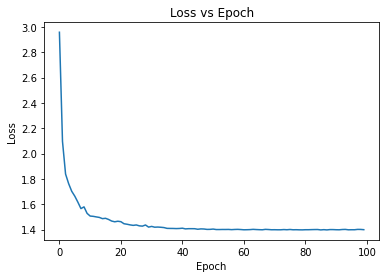

In [9]:
plt.plot(range(epochs), training_loss)
# plt.plot(range(epochs), validation_loss)
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()